<a href="https://colab.research.google.com/github/anyaconda/myAroundML/blob/main/my_wandb_DL_FundamentalsWithW%26B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🪨📄✂️ Shoot!

In this notebook we'll go over some of the common mistakes that I've encountered as I learned how to train deep learning models.  We'll begin manually tweeking hyper-parameters, then we'll run a sweep, finally we'll evaluate some of the models we've created.  More examples and detailed documentation are available on our [documentation site](https://docs.wandb.com).

To get started we need to [signup or login](https://wandb.ai/login) to W&B and install the library.

In [1]:
!pip install -qq wandb

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import wandb
import os
from IPython.display import clear_output 
os.environ["WANDB_ENTITY"] = "anya"

## 0. Load data
We're loading our 🪨📄✂️ dataset from [tensorflow datasets](https://www.tensorflow.org/datasets/catalog/overview).  There are lots of great datasets you can experiment with here.

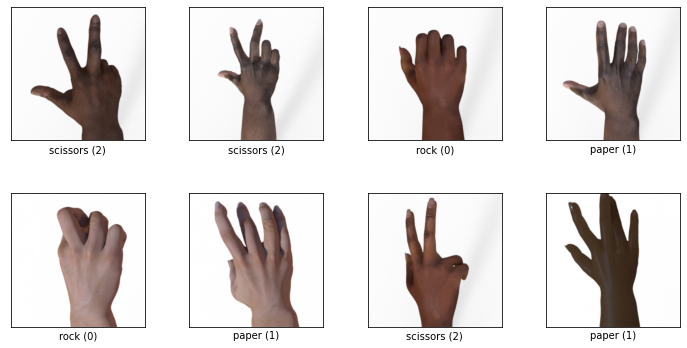

In [3]:
ds, info = tfds.load(name="rock_paper_scissors", with_info=True)
NUM_CLASSES = 3
clear_output()

get_name = lambda idx: info.features['label'].int2str(idx).split("-")[-1].replace("_", " ")
get_id = lambda tensor: tensor.numpy().decode('utf-8').split("/")[-1]

fig = tfds.show_examples(ds['train'], info, cols=4, rows=2)

## 1. Prep Data
We define a few utility functions for preprocessing our data below.  We'll modify these as we iterate on our model.

In [13]:
IMG_LEN = 224
IMG_SHAPE = (IMG_LEN,IMG_LEN,3)

# Let's use a metric to capture the distribution of the input data
mean_input = tf.keras.metrics.MeanTensor()
def log_distribution(epoch, logs):
  """Log the input distribution on the first epoch"""
  if epoch == 0:
    wandb.log({"inputs": wandb.Histogram(mean_input.result().numpy())}, commit=False)
custom_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_distribution)

def preprocess(ds_row):
  """Preprocess our image data"""
  image = ds_row['image']
  image = tf.image.resize(image, (IMG_LEN, IMG_LEN), method='nearest')
  image = tf.image.random_brightness(image, 0.3)
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  image = tf.image.random_flip_left_right(image)
  mean_input.update_state(image)
  # One hot encoding labels
  label = tf.one_hot(ds_row['label'],NUM_CLASSES)

  return image, label

def prepare(dataset, batch_size=None, x=4):
  """Preprocess, shuffle and optionally batch the data"""
  ds = dataset.map(preprocess, num_parallel_calls=x)
  ds = ds.shuffle(buffer_size=100)
  if batch_size:
    ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

## 2. Model 
We build our model in a function so that we can easily sweep over different model configurations.

In [14]:
def build_model(model="MobileNetV2", hidden_nodes=32, dropout=0.4):
  """Returns a keras model based on various combiniations of hyper-parameters"""
  Model = getattr(tf.keras.applications, model) #EfficientNetB0, etc. https://keras.io/api/applications
  base_model = Model(input_shape=IMG_SHAPE,
                    include_top=False,
                    pooling='average',
                    weights='imagenet')
  base_model.trainable = False

  return tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(hidden_nodes, activation='relu'),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
  ])

Here we define our primary training function.  Notice we're calling wandb.init to log the experiment and it's hyper-parameters to W&B.  We also added the WandbCallback.

In [17]:
cfg_defaults={
  "lr": 0.00030, 
  "batch_size": 64,
  "epochs": 5,
  "dropout": 0.4,
  "model": "MobileNetV2",
  "hidden_nodes": 16 #32
}
def train():
  with wandb.init(project="my-shoot", config=cfg_defaults) as run:
    mean_input.reset_states()
    model = build_model(run.config.model, run.config.hidden_nodes, run.config.dropout)
    model.compile(optimizer=tf.keras.optimizers.Adamax(run.config.lr),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    run.config.update({"total_params": model.count_params()})
            
    train_batches = prepare(ds['train'], batch_size=run.config.batch_size)
    test_batches = prepare(ds['test'], batch_size=run.config.batch_size)
    wandb_callback = wandb.keras.WandbCallback(data_type="image", validation_data=test_batches, labels=["Rock", "Paper", "Scissors"])
    history = model.fit(train_batches, epochs=run.config.epochs,
                        validation_data=test_batches, callbacks=[custom_callback, wandb_callback])

### 2.1 Train
Let's actually train our first model.

In [18]:
train()

Epoch 1/5
40/40 [==============================] - 18s 376ms/step - loss: 0.8869 - accuracy: 0.7090 - val_loss: 0.2035 - val_accuracy: 0.9032
Epoch 2/5
40/40 [==============================] - 15s 366ms/step - loss: 0.1369 - accuracy: 0.9446 - val_loss: 0.1684 - val_accuracy: 0.9301
Epoch 3/5
40/40 [==============================] - 15s 362ms/step - loss: 0.1132 - accuracy: 0.9561 - val_loss: 0.1522 - val_accuracy: 0.9382
Epoch 4/5
40/40 [==============================] - 15s 364ms/step - loss: 0.1001 - accuracy: 0.9629 - val_loss: 0.1603 - val_accuracy: 0.9328
Epoch 5/5
40/40 [==============================] - 15s 359ms/step - loss: 0.0824 - accuracy: 0.9698 - val_loss: 0.1153 - val_accuracy: 0.9570


epoch,4
loss,0.08886
accuracy,0.96548
val_loss,0.11529
val_accuracy,0.95699
_runtime,89
_timestamp,1613183084
_step,4
best_val_loss,0.11529
best_epoch,4


epoch,▁▃▅▆█
loss,█▂▁▁▁
accuracy,▁▇▇██
val_loss,█▅▄▅▁
val_accuracy,▁▅▆▅█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


### 2.2 Sweeps for Hyperparamter tuning 
We can explore some different combinations of hyper-parameters using [W&B Sweeps](https://docs.wandb.ai/sweeps).  First let's go create a sweep in the UI and use the identifier below.

In [21]:
#wandb agent anya/my-shoot/71k67290
SWEEP_ID="anya/my-shoot/71k67290"
wandb.agent(SWEEP_ID, function=train, count=5)

wandb: Agent Starting Run: exfjk4o8 with config:
wandb: 	hidden_nodes: 14
wandb: 	lr: 0.00046621551711578495
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/5
40/40 [==============================] - 20s 416ms/step - loss: 1.2402 - accuracy: 0.4624 - val_loss: 0.5806 - val_accuracy: 0.8038
Epoch 2/5
40/40 [==============================] - 16s 396ms/step - loss: 0.5486 - accuracy: 0.6547 - val_loss: 0.5139 - val_accuracy: 0.8414
Epoch 3/5
40/40 [==============================] - 16s 392ms/step - loss: 0.5032 - accuracy: 0.6707 - val_loss: 0.5972 - val_accuracy: 0.8575
Epoch 4/5
40/40 [==============================] - 17s 395ms/step - loss: 0.4530 - accuracy: 0.6876 - val_loss: 0.6724 - val_accuracy: 0.8065
Epoch 5/5
40/40 [==============================] - 17s 386ms/step - loss: 0.4364 - accuracy: 0.6842 - val_loss: 0.5841 - val_accuracy: 0.8737


epoch,4
loss,0.41949
accuracy,0.7004
val_loss,0.58409
val_accuracy,0.87366
_runtime,96
_timestamp,1613186092
_step,4
best_val_loss,0.5139
best_epoch,1


epoch,▁▃▅▆█
loss,█▃▂▂▁
accuracy,▁▆▇▇█
val_loss,▄▁▅█▄
val_accuracy,▁▅▆▁█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: mtoji4pf with config:
wandb: 	hidden_nodes: 9
wandb: 	lr: 0.00018251549884799835
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/5
40/40 [==============================] - 19s 411ms/step - loss: 1.0856 - accuracy: 0.5657 - val_loss: 0.3620 - val_accuracy: 0.9382
Epoch 2/5
40/40 [==============================] - 16s 390ms/step - loss: 0.4575 - accuracy: 0.7305 - val_loss: 0.2685 - val_accuracy: 0.9812
Epoch 3/5
40/40 [==============================] - 16s 393ms/step - loss: 0.3914 - accuracy: 0.7652 - val_loss: 0.2541 - val_accuracy: 0.9758
Epoch 4/5
40/40 [==============================] - 16s 397ms/step - loss: 0.3909 - accuracy: 0.7537 - val_loss: 0.2266 - val_accuracy: 0.9892
Epoch 5/5
40/40 [==============================] - 16s 394ms/step - loss: 0.3499 - accuracy: 0.7776 - val_loss: 0.2210 - val_accuracy: 0.9704


epoch,4
loss,0.35086
accuracy,0.78611
val_loss,0.22095
val_accuracy,0.97043
_runtime,96
_timestamp,1613186194
_step,4
best_val_loss,0.22095
best_epoch,4


epoch,▁▃▅▆█
loss,█▃▂▂▁
accuracy,▁▆▆▇█
val_loss,█▃▃▁▁
val_accuracy,▁▇▆█▅
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: gxldwvr2 with config:
wandb: 	hidden_nodes: 8
wandb: 	lr: 0.0002835637694321943
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/5
40/40 [==============================] - 19s 409ms/step - loss: 0.9618 - accuracy: 0.5583 - val_loss: 0.6679 - val_accuracy: 0.8978
Epoch 2/5
40/40 [==============================] - 16s 395ms/step - loss: 0.6148 - accuracy: 0.7730 - val_loss: 0.6314 - val_accuracy: 0.8710
Epoch 3/5
40/40 [==============================] - 16s 394ms/step - loss: 0.5662 - accuracy: 0.8112 - val_loss: 0.5918 - val_accuracy: 0.8763
Epoch 4/5
40/40 [==============================] - 17s 406ms/step - loss: 0.5630 - accuracy: 0.8127 - val_loss: 0.6156 - val_accuracy: 0.8172
Epoch 5/5
40/40 [==============================] - 17s 397ms/step - loss: 0.5630 - accuracy: 0.7945 - val_loss: 0.5888 - val_accuracy: 0.8360


epoch,4
loss,0.57454
accuracy,0.80238
val_loss,0.58882
val_accuracy,0.83602
_runtime,98
_timestamp,1613186297
_step,4
best_val_loss,0.58882
best_epoch,4


epoch,▁▃▅▆█
loss,█▂▁▁▁
accuracy,▁▆███
val_loss,█▅▁▃▁
val_accuracy,█▆▆▁▃
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: v0nxljev with config:
wandb: 	hidden_nodes: 5
wandb: 	lr: 0.00035788666255057763
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/5
40/40 [==============================] - 19s 412ms/step - loss: 1.0153 - accuracy: 0.4764 - val_loss: 0.7041 - val_accuracy: 0.9301
Epoch 2/5
40/40 [==============================] - 16s 397ms/step - loss: 0.7674 - accuracy: 0.6983 - val_loss: 0.7616 - val_accuracy: 0.8038
Epoch 3/5
40/40 [==============================] - 17s 391ms/step - loss: 0.7113 - accuracy: 0.7319 - val_loss: 0.6943 - val_accuracy: 0.8333
Epoch 4/5
40/40 [==============================] - 16s 393ms/step - loss: 0.6880 - accuracy: 0.7303 - val_loss: 0.6698 - val_accuracy: 0.8360
Epoch 5/5
40/40 [==============================] - 16s 392ms/step - loss: 0.6956 - accuracy: 0.7119 - val_loss: 0.6732 - val_accuracy: 0.8306


epoch,4
loss,0.69001
accuracy,0.73056
val_loss,0.6732
val_accuracy,0.83065
_runtime,96
_timestamp,1613186398
_step,4
best_val_loss,0.66979
best_epoch,3


epoch,▁▃▅▆█
loss,█▃▂▁▁
accuracy,▁████
val_loss,▄█▃▁▁
val_accuracy,█▁▃▃▂
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 9uqg0rwt with config:
wandb: 	hidden_nodes: 6
wandb: 	lr: 0.0004687507707477191
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/5
40/40 [==============================] - 19s 406ms/step - loss: 1.5472 - accuracy: 0.3369 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 2/5
40/40 [==============================] - 17s 401ms/step - loss: 1.0986 - accuracy: 0.3270 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 3/5
40/40 [==============================] - 17s 398ms/step - loss: 1.0986 - accuracy: 0.3279 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 4/5
40/40 [==============================] - 16s 392ms/step - loss: 1.0986 - accuracy: 0.3256 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 5/5
40/40 [==============================] - 16s 393ms/step - loss: 1.0986 - accuracy: 0.3329 - val_loss: 1.0986 - val_accuracy: 0.3333


epoch,4
loss,1.09862
accuracy,0.33333
val_loss,1.09861
val_accuracy,0.33333
_runtime,96
_timestamp,1613186500
_step,4
best_val_loss,1.09861
best_epoch,4


epoch,▁▃▅▆█
loss,█▁▁▁▁
accuracy,█▁▁▁▁
val_loss,██▆▃▁
val_accuracy,▁▁▁▁▁
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


After our sweep has completed.  We can use the W&B Api to find our best run and download the model file so we can use it for making predictions.

In [22]:
api = wandb.Api()
sweep = api.sweep(SWEEP_ID)
run = sweep.best_run()
print("Best run: ", run.url)
print("Accuracy: ", run.summary["val_accuracy"])
model_file = run.file("model-best.h5").download(replace=True).name
model = tf.keras.models.load_model(model_file)

wandb: Sorting runs by +summary_metrics.val_loss


Best run:  https://wandb.ai/anya/my-shoot/runs/mtoji4pf
Accuracy:  0.9704301357269288


Finally, we construct a [W&B Data Viz Table](https://docs.wandb.ai/datasets-and-predictions) to analyize our results.

In [23]:
prediction_table = wandb.Table(
    columns=["image", "label", "best_pred", "best_pred_score", "actual_pred_score", "top_preds"]
)
progress = wandb.sdk.lib.ipython.jupyter_progress_bar()
with wandb.init(project="shoot", job_type="eval") as run:
  # Create a table with predictions and truth
  print("Evaluating model...")
  BATCH_SIZE = 64
  batched_dataset = prepare(ds['test'], batch_size=BATCH_SIZE)
  for batch, (imgs, labels) in enumerate(batched_dataset):
    total = len(ds['test'])
    progress.update(batch / (total / BATCH_SIZE), "Evaluated {} of {} examples".format(batch * BATCH_SIZE, total))
    preds = model(imgs)

    actuals = [tf.argmax(label) for label in labels]
    top_components_preds = [tf.reshape(tf.math.top_k(pred, k=NUM_CLASSES-1).indices,shape=[-1]) for pred in preds]
    top_matches_preds = []
    for comps in top_components_preds:
      top_matches_preds.append([get_name(comp) for comp in comps])

    actual_pred_scores = [preds[i,actual].numpy()*1.0 for i, actual in enumerate(actuals)]
    best_pred_scores = [pred[tf.argmax(pred)].numpy()*1.0 for pred in preds] 
    best_pred_labels = [get_name(tf.argmax(pred)) for pred in preds]
    for i, img in enumerate(imgs):
      prediction_table.add_data(wandb.Image(img), get_name(actuals[i]), best_pred_labels[i], best_pred_scores[i], actual_pred_scores[i], top_matches_preds[i])
  progress.close()

  # Join our existing test data artifact to this new prediction artifact
  eval_artifact = wandb.Artifact(name="evaluation", type="dataset")
  eval_artifact.add(prediction_table, "predictions")
  run.log_artifact(eval_artifact)

wandb: WARNING Ignored wandb.init() arg project when running a sweep


Evaluating model...


$note: VizTable with latest run.  Ideally, would want the best run with the best model.